In [1]:
import pandas as pd
# import dfply
import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
data = pd.read_csv("prep_data.csv")

In [3]:
data.head()

,device,cluster,test,category,system,browser,date,clicks,views,visits
0,komputor,0,baza ortogonalna,SupaHot,Windows,Firefox,2016-01-01,2218.815491,4969.973884,7100
1,smartfon,0,baza ortogonalna,SupaHot,Windows,Firefox,2016-01-01,901.326075,3645.000000,5436
2,dumbfon,0,baza ortogonalna,SupaHot,Windows,Firefox,2016-01-01,951.971173,3468.000000,5481
3,komputor,1,baza ortogonalna,SupaHot,Windows,Firefox,2016-01-01,1318.905449,4139.663801,5571
4,smartfon,1,baza ortogonalna,SupaHot,Windows,Firefox,2016-01-01,607.872064,2863.000000,4055


In [4]:
dt_gr = data.groupby('test')

summ_global = dt_gr.agg({'clicks': sum, 'visits': sum}).round()
summ_global['ctr'] = round(100*summ_global.clicks/summ_global.visits, 2)
summ_global['category'] = 'Global'
summ_global = summ_global.rename(columns={'visits':'views'})
summ_global.reset_index(level=0, inplace=True)
summ_global = summ_global.set_index(['test', 'category'])
summ_global

,,clicks,views,ctr
test,category,,,
CienkiBolek,Global,3504277.0,6816753,51.41
DataScienceRocks,Global,4461298.0,6897788,64.68
baza ortogonalna,Global,4259370.0,6835213,62.32
fan,Global,4272179.0,6942520,61.54
megatron30000,Global,4324564.0,6894112,62.73


In [5]:
# Other approaches:

# ctr = round(100 * dt_gr['clicks'].sum() / dt_gr['visits'].sum(), 2)
ctr = dt_gr.pipe(lambda grp: 100*grp.clicks.sum()/grp.visits.sum()).round(2)
ctr.name = 'ctr'
others = dt_gr[['visits','clicks']].sum().round()
# summ_global = pd.concat([others, ctr], axis=1, join='outer')
summ_global = others.join(ctr, how='outer')
summ_global['category'] = 'Global'
summ_global = summ_global.rename(columns={'visits':'views'})
summ_global.reset_index(level=0, inplace=True)
summ_global = summ_global.set_index(['test', 'category'])
summ_global

,,views,clicks,ctr
test,category,,,
CienkiBolek,Global,6816753,3504277.0,51.41
DataScienceRocks,Global,6897788,4461298.0,64.68
baza ortogonalna,Global,6835213,4259370.0,62.32
fan,Global,6942520,4272179.0,61.54
megatron30000,Global,6894112,4324564.0,62.73


In [6]:
summ_categories = data.groupby(['test', 'category']) \
    .agg({'clicks': sum, 'views': sum}).round()
summ_categories['ctr'] = round(100*summ_categories.clicks/summ_categories.views, 2)

In [7]:
summ = summ_global.append(summ_categories) \
        .reset_index() \
        .melt(id_vars=['test', 'category'], var_name='measure', value_name='value')
summ.set_index(['test', 'category', 'measure']).unstack(level=0)

value                                    \
test                   CienkiBolek DataScienceRocks baza ortogonalna   
category       measure                                                 
Global         clicks   3504277.00       4461298.00       4259370.00   
               ctr           51.41            64.68            62.32   
               views    6816753.00       6897788.00       6835213.00   
LatestNews     clicks   1177048.00       1494690.00       1428750.00   
               ctr           27.28            34.21            32.52   
               views    4314084.00       4369225.00       4394090.00   
SupaHot        clicks   1146071.00       1477157.00       1400009.00   
               ctr           26.37            33.89            32.12   
               views    4345411.00       4358453.00       4358302.00   
ZawszeSmieszne clicks   1181157.00       1489451.00       1430611.00   
               ctr           27.16            34.29            32.77   
               views    4349463.00       4343073.00       4365645.00   

                                                  
test                           fan megatron30000  
category       measure                            
Global         clicks   4272179.00    4324564.00  
               ctr           61.54         62.73  
               views    6942520.00    6894112.00  
LatestNews     clicks   1419347.00    1447804.00  
               ctr           32.24         33.13  
               views    4401880.00    4370123.00  
SupaHot        clicks   1432800.00    1446928.00  
               ctr           32.84         33.29  
               views    4362595.00    4346486.00  
ZawszeSmieszne clicks   1420032.00    1429832.00  
               ctr           32.39         33.06  
               views    4384375.00    4324769.00

# Distribution

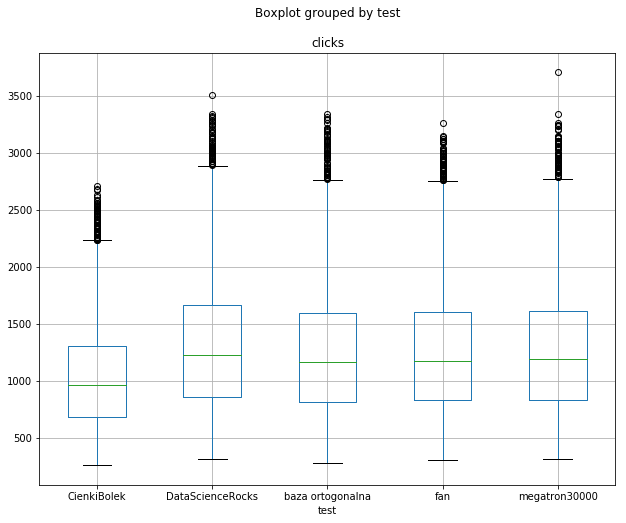

In [8]:
data.boxplot(column='clicks', by='test', figsize=(10, 8))

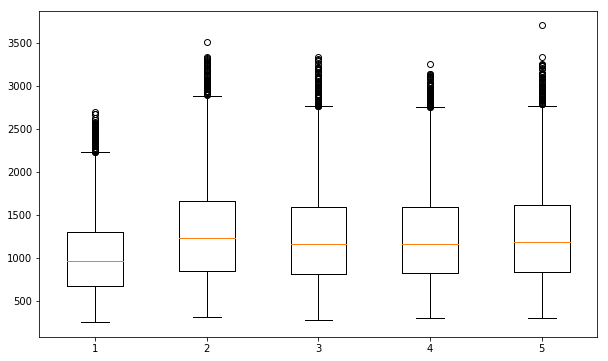

In [9]:
fig, ax1 = plt.subplots(figsize=(10, 6))
fig.canvas.set_window_title('A Boxplot Example')

bp_data = []
for tst_name, tst_data in data.groupby('test'):
    bp_data.append(tst_data['clicks'])

bp = plt.boxplot(bp_data)
plt.show()

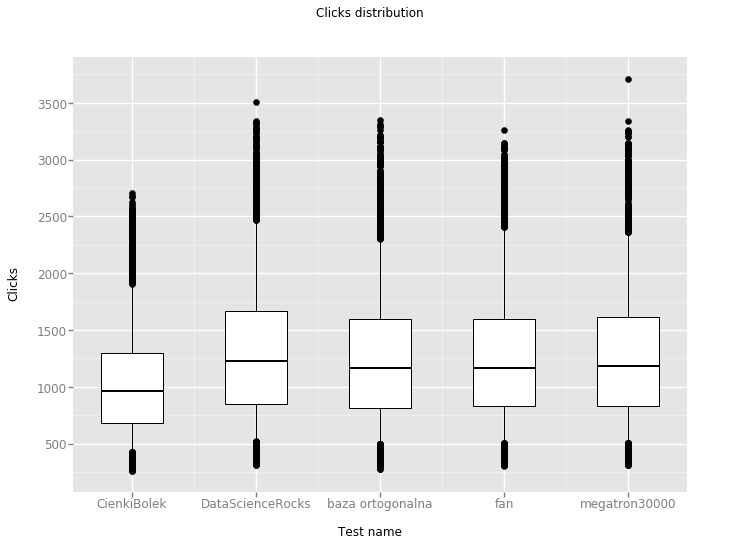

<ggplot: (-9223363284702911856)>

In [22]:
from ggplot import *

ggplot(aes(x='test', y='clicks'), data=data) + \
    geom_boxplot() + \
    labs(x = "Test name"
        , y = "Clicks"
        , title = "Clicks distribution")

# It seems that:
#   - there is no subtitle and caption in labs()
#   - there is no annotate function

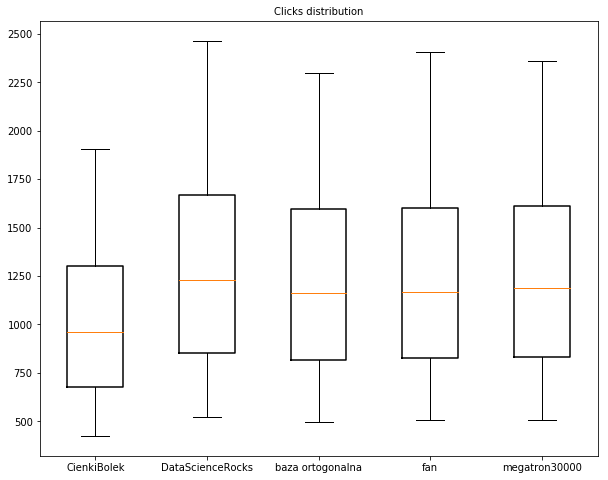

In [54]:
# Custom boxplot
bx_stats = data.groupby('test')['clicks'] \
    .quantile([0.05, 0.25, 0.5, 0.75, 0.95]) \
    .reset_index() \
    .rename(columns={'level_1':'rank'}) \
    .pivot(index='rank', columns='test', values='clicks')

fin_stats = []
for col in bx_stats.columns:
    fin_stats.append({
        'label': col,
        'mean': data[data['test'] == col].clicks.mean(),
        'iqr': bx_stats[col].loc[0.75] - bx_stats[col].loc[0.25],
        'whislo': bx_stats[col].loc[0.05],
        'whishi': bx_stats[col].loc[0.95],
        'q1': bx_stats[col].loc[0.25],
        'med': bx_stats[col].loc[0.5],
        'q3': bx_stats[col].loc[0.75],
        'fliers': []
    })

fig, axes = plt.subplots(figsize=(10,8))
axes.bxp(fin_stats)
axes.set_title('Clicks distribution', fontsize=10)
plt.show()